In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import numpy as np
import cv2
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.functional as F

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [15]:
class ThreatDataset(Dataset):
    def __init__(self, data, loader_type='train', transforms = None):
        self.folder_names = ['carrying', 'threat', 'normal']
        self.data = data
        self.transform = transforms
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.folder_names.index(data.parent.name)
        image = cv2.imread(str(data))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, label

In [16]:
import random
from pathlib import Path

def split_data(data_dir, train_size=0.8, val_size = 0.1):
    random.seed(1234)
    data = Path('data').glob('*/*')
    data = [x for x in data if x.is_file() and x.suffix != '.zip']
    random.shuffle(data)
    train_size = int(len(data) * train_size)
    val_size = int(len(data) * val_size)
    train_data = data[:train_size]
    val_data = data[train_size:train_size+val_size]
    test_data = data[train_size+val_size:]

    return train_data, val_data, test_data


train_data, val_data, test_data = split_data('data')

In [17]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms = {
    'train': train_transforms,
    'val': val_transforms,
    'test': test_transforms
}

train_dataset = ThreatDataset(train_data, loader_type="train", transforms=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [18]:
from scripts import dataloader

train_loader, val_loader, test_loader = dataloader.get_loaders()

In [19]:
x, y = iter(train_loader).next()
torch.argmax(F.one_hot(y, num_classes=3), 1)

tensor([2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 0, 2, 1, 2, 0, 2, 1, 2,
        1, 1, 2, 0, 0, 1, 1, 2])

In [20]:
# For NLLLoss, we need to use the logit distribution
# https://discuss.pytorch.org/t/what-is-the-difference-between-nllloss-and-crossentropyloss/15553
# The CrossEntropyLoss combines the LogSoftmax and NLLLoss in one single class
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
# https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html

class Trainer:
    def __init__(self, model, optimizer, criterion, scheduler, device):
        # The trainer uses a one-hot distribution for the labels, so we need to use the CrossEntropyLoss
        # instead of the NLLLoss
        # Using FCC layer as the last layer, we can try to use basic loss functions like MSE or L1
        
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.best_acc = 0.5
        if (device == 'cuda') and torch.cuda.is_available():
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')

    def train(self, train_loader, val_loader, epochs=10):
        self.model.to(self.device)
        total = 0
        correct = 0
        for epoch in range(epochs):
            print(f"EPOCH {epoch}")
            self.model.train()
            tq = tqdm(enumerate(train_loader))
            for i, (x, y) in tq:
                x = x.to(self.device)
                y_label = y
                y = F.one_hot(y, num_classes=3).to(self.device).float()
                total += y.size(0)
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                loss = self.criterion(y_pred, y)
                loss.backward()
                self.optimizer.step()
                
                # Calculate Accuracy - Only for softmax/logit distributions  
                _, predicted = torch.max(y_pred.data, 1)
                correct += (predicted.cpu() == y_label).sum().item()
                tq.set_postfix(loss=loss.item(), acc=correct/total)
                if i % 100 == 0:
                    print(f'Epoch: {epoch}, Loss: {loss.item()}')
            self.validate(val_loader)
            self.scheduler.step()
            print(f'Epoch: {epoch}, Accuracy: {correct/total}')

    def validate(self, val_loader):
        self.model.eval()
        total = 0
        correct = 0
        with torch.no_grad():
            tq = tqdm(enumerate(val_loader))
            for i, (x, y) in tq:
                x = x.to(self.device)
                y_label = y
                y = F.one_hot(y, num_classes=3).to(self.device).float()
                y_pred = self.model(x)
                loss = self.criterion(y_pred, y)

                total += y.size(0)
                _, predicted = torch.max(y_pred.data, 1)
                # print(predicted)
                
                correct += (predicted.cpu() == y_label).sum().item()
                if i % 100 == 0:
                    print(f'Validation Loss: {loss.item()}')
            print(f'Validation Accuracy: {correct/total}')
            if correct/total > self.best_acc:
                self.best_acc = correct/total
                print('Saving model...')
                torch.save(self.model.state_dict(), 'best_model.pth')
    
    def test(self, test_loader):
        self.model.eval()
        total = 0
        correct = 0
        with torch.no_grad():
            for i, (x, y) in tqdm(enumerate(test_loader)):
                x = x.to(self.device)
                y_label = y
                y = F.one_hot(y, num_classes=3).to(self.device).float()
                total += y.size(0)
                y_pred = self.model(x)
                loss = self.criterion(y_pred, y)

                _, predicted = torch.max(y_pred.data, 1)
                correct += (predicted.cpu() == y_label).sum().item()
                if i % 100 == 0:
                    print(f'Test Loss: {loss.item()}')
        print(f'Accuracy: {100 * correct / total}')
    
    def save_model(self, path):
        torch.save(self.model.state_dict(), path)      

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path)) 

In [8]:
from torchvision.models import resnet18, resnet101
from torch.optim.lr_scheduler import StepLR
# from torch import nn
import torch.optim as optim 

model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 3)

model.load_state_dict(torch.load('best_model_25.pth',  map_location=torch.device('cpu')))

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# trainer = Trainer(model, optimizer, criterion, scheduler, 'cuda')
# trainer.train(train_loader, val_loader, epochs=10)


In [11]:
sum(p.numel() for p in model.parameters())

11178051

In [ ]:
class Res101Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = resnet101(pretrained=True)
        self.model.fc = nn.Linear(2048, 512)
        self.fc_2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.model(x)
        x = self.fc_2(x)
        return x   

In [ ]:
from torchvision.models import efficientnet_b2

class EffNetModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = efficientnet_b2(pretrained=True)
        self.model._fc = nn.Linear(1408, 512)
        self.fc_2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.model(x)
        x = self.fc_2(x)
        return x



In [7]:
import cv2 
from pathlib import Path 
import numpy as np

img = Path.cwd() / 'data' / 'normal' / '00000.42797_30.png'
img = cv2.imread(str(img))
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(img.shape)
# img = cv2.resize(img, (224, 224))
img = np.dstack((img, img, img))
print(img.shape)

(1440, 1080, 3)
(1440, 1080)
(1440, 1080, 3)


In [ ]:
from scripts.triplet_trainer import runner

trainer = runner()

In [138]:
import matplotlib.pyplot as plt 
import numpy as np

file = open('resnet_18.txt', 'r')
lines = file.readlines()
for i in range(5):
    print(lines[i])

COLOR SPACE :  gray 


EPOCH 0

Epoch: 0, Loss: 1.0964722633361816

Validation Loss: 1.0143122673034668



In [139]:
from collections import defaultdict

result_dict = defaultdict(lambda: defaultdict(list))

epoch_val = 0
for line in lines:
    line = line.strip()
    if 'COLOR SPACE' in line:
        print(line.split(' '))
        color_space = line.split(' ')[-1].strip()
        print(color_space)
        result_dict[color_space] = defaultdict(list)
    elif 'EPOCH' in line:
        epoch = line.split(' ')[-1].strip()
        epoch_val = int(epoch)
        result_dict[color_space][epoch] = []
    elif 'Validation Loss' in line:
        loss = line.split(' ')[-1].strip()
        result_dict[color_space][epoch].append(float(loss))
    elif 'Loss' in line:
        loss = line.split(' ')[-1].strip()
        result_dict[color_space][epoch].append(float(loss))
    elif 'Validation Accuracy' in line:
        acc = line.split(' ')[-1].strip()
        result_dict[color_space][epoch].append(float(acc))

file.close()


['COLOR', 'SPACE', ':', '', 'gray']
gray
['COLOR', 'SPACE', ':', '', 'rgb']
rgb
['COLOR', 'SPACE', ':', '', 'hsv']
hsv
['COLOR', 'SPACE', ':', '', 'lab']
lab


In [17]:
import pprint 

pprint.pprint(result_dict['gray'])

defaultdict(<class 'list'>,
            {'0': [1.0964722633361816, 1.0143122673034668, 0.5153846153846153],
             '1': [0.9623447060585022, 0.885516881942749, 0.5435897435897435],
             '10': [0.8513211011886597, 0.9050747156143188, 0.617948717948718],
             '11': [0.8084173202514648, 0.8274877667427063, 0.6076923076923076],
             '12': [0.8049342632293701, 0.6575773358345032, 0.6307692307692307],
             '13': [0.93867027759552, 0.8921164870262146, 0.617948717948718],
             '14': [0.8565928936004639, 0.9514455795288086, 0.617948717948718],
             '15': [0.5504538416862488, 0.8917946815490723, 0.6461538461538462],
             '16': [0.8470953702926636, 0.681524395942688, 0.6641025641025641],
             '17': [0.7245916128158569, 0.8394550085067749, 0.6410256410256411],
             '18': [0.7107518911361694, 0.8842114210128784, 0.6358974358974359],
             '19': [0.7090344429016113, 0.8272356986999512, 0.6794871794871795],
         

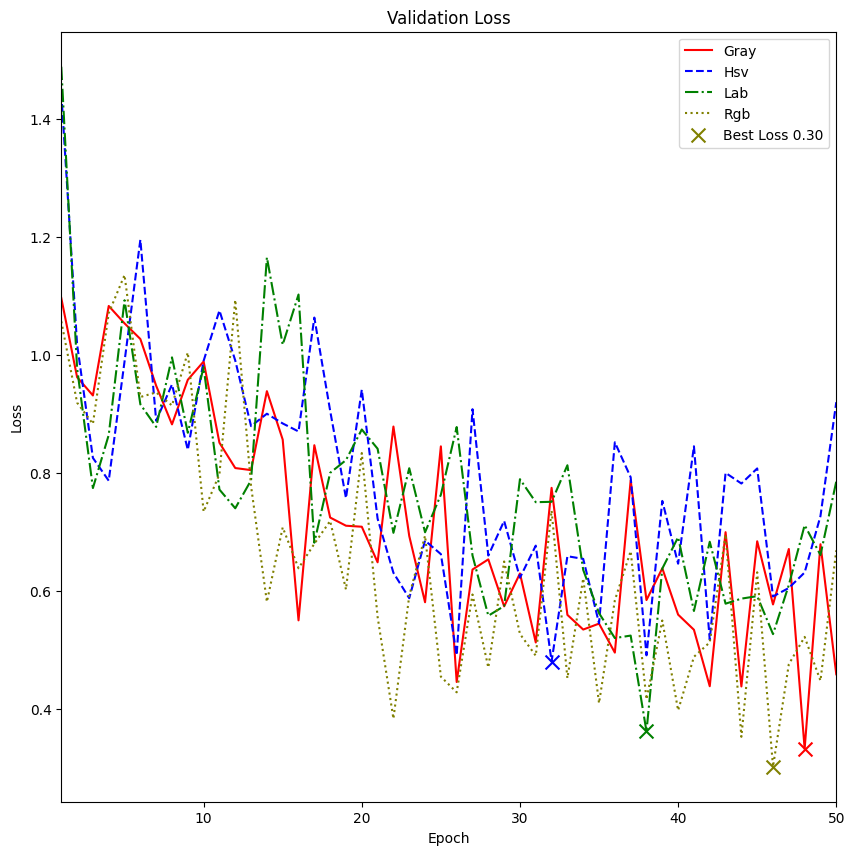

In [162]:

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

colors = ['red', 'blue', 'green', 'olive', 'purple', 'black', 'pink', 'brown', 'gray', 'olive', 'cyan']
linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.']
for idx, color_space in enumerate(['gray', 'hsv', 'lab', 'rgb']):
    val_losses = []
    train_losses = []
    val_acc = []

    for i in range(50):
        val_losses.append(result_dict[color_space][str(i)][0])
        train_losses.append(result_dict[color_space][str(i)][1])
        val_acc.append(result_dict[color_space][str(i)][2])
    ax.plot(range(1, len(val_losses) + 1), val_losses, label=f'{color_space.title()}', color=colors[idx], linestyle=linestyles[idx])

    if idx == 3:
        plt.scatter(val_losses.index(min(val_losses)) + 1, min(val_losses), marker='x', color=colors[idx], s=100, label=f'Best Loss {min(val_losses):.2f}')
    else:
        plt.scatter(val_losses.index(min(val_losses)) + 1, min(val_losses), marker='x', color=colors[idx], s=100)

    ax.set_title('Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_xlim(1, 50)


ax.legend()
plt.show()


68.71794871794872
50
70.51282051282051
50
73.33333333333333
50
72.56410256410255
50


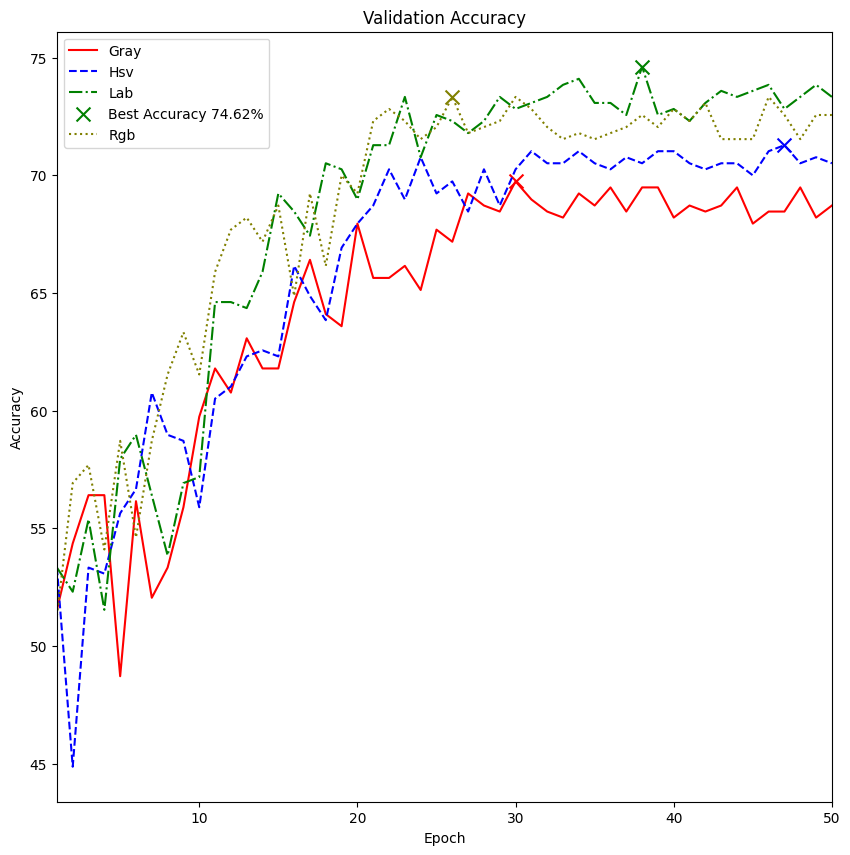

In [166]:

fig, ax = plt.subplots(1, 1, figsize=(10, 10))


for idx, color_space in enumerate(['gray', 'hsv', 'lab', 'rgb']):
    val_losses = []
    train_losses = []
    val_acc = []

    for i in range(50):
        val_losses.append(result_dict[color_space][str(i)][0])
        train_losses.append(result_dict[color_space][str(i)][1])
        val_acc.append(result_dict[color_space][str(i)][2] * 100)
    print(val_acc[49])
    print(len(val_acc))
    ax.plot(range(1, len(val_acc) + 1), val_acc, label=f'{color_space.title()}', color=colors[idx], linestyle=linestyles[idx])

    if idx == 2:
        plt.scatter(val_acc.index(max(val_acc)) + 1, max(val_acc), marker='x', color=colors[idx], s=100, label='Best Accuracy {:.2f}%'.format(max(val_acc)))
    else:
        plt.scatter(val_acc.index(max(val_acc)) + 1, max(val_acc), marker='x', color=colors[idx], s=100)
    ax.set_title('Validation Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_xlim(1, 50)


    ax.legend()
ax.legend()
plt.show()


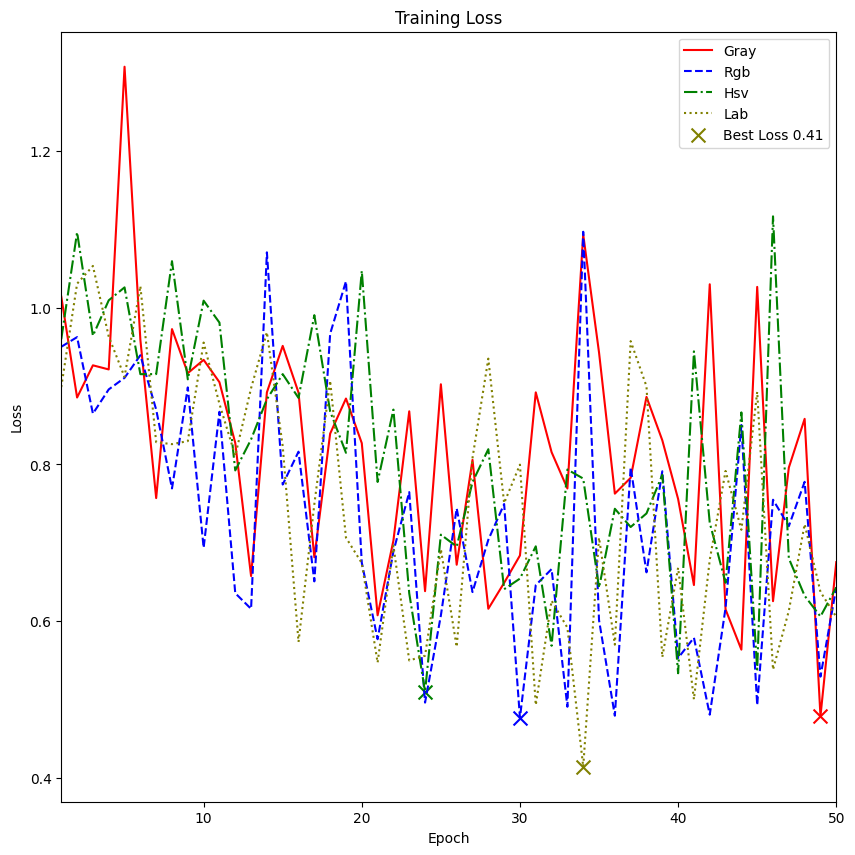

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for idx, color_space in enumerate(result_dict):
    val_losses = []
    train_losses = []
    val_acc = []

    for i in range(50):
        val_losses.append(result_dict[color_space][str(i)][0])
        train_losses.append(result_dict[color_space][str(i)][1])
        val_acc.append(result_dict[color_space][str(i)][2] * 100)

    ax.plot(range(1, len(train_losses) + 1), train_losses, label=f'{color_space.title()}', color=colors[idx], linestyle=linestyles[idx])

    ax.set_title('Training Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_xlim(1, 50)

    if idx == 3:
        plt.scatter(train_losses.index(min(train_losses)) + 1, min(train_losses), marker='x', color=colors[idx], s=100, label='Best Loss {:.2f}'.format(min(train_losses)))
    else:
        plt.scatter(train_losses.index(min(train_losses)) + 1, min(train_losses), marker='x', color=colors[idx], s=100)
    

ax.legend()
plt.show()


In [82]:
file = open('bifpn_vanilla.txt', 'r')
lines = file.readlines()
for i in range(5):
    print(lines[i])

file.close()

TRAINING

Phase train:

100%

495/495 [08:07<00:00, 1.35it/s]

Phase val:



In [83]:
result_dict = defaultdict(list)

train_losses = []
val_losses = []
train_acc = []
val_acc = []

epoch_val = 0
for line in lines:
    line_split = line.strip().split(' ')
    if 'TRAIN ' in line:
        print(line_split)
        train_losses.append(float(line_split[2][:-1]))
        train_acc.append(float(line_split[5])* 100) 
    elif 'VAL' in line and 'IMPROVED' not in line:
        print(line_split)
        val_losses.append(float(line_split[2][:-1]))
        val_acc.append(float(line_split[-1]) * 100)

bifpn_dict = defaultdict(list)
bifpn_dict['vanilla'] = [train_losses, val_losses, train_acc, val_acc]

['TRAIN', 'LOSS:', '0.5615630078797389', 'TRAIN', 'ACC:', '0.3431818181818182', '', 'EPOCH:', '0']
['VAL', 'LOSS:', '0.554400134471155,', 'EPOCH:', '0,', 'ACC:', '0.3743279569892473']
['TRAIN', 'LOSS:', '0.5591184449918343', 'TRAIN', 'ACC:', '0.36717171717171715', '', 'EPOCH:', '1']
['VAL', 'LOSS:', '0.5555600466266755,', 'EPOCH:', '1,', 'ACC:', '0.35551075268817206']
['TRAIN', 'LOSS:', '0.5548728295046874', 'TRAIN', 'ACC:', '0.4904040404040404', '', 'EPOCH:', '2']
['VAL', 'LOSS:', '0.5423792485267885,', 'EPOCH:', '2,', 'ACC:', '0.5981182795698925']
['TRAIN', 'LOSS:', '0.5402779705596693', 'TRAIN', 'ACC:', '0.6353535353535353', '', 'EPOCH:', '3']
['VAL', 'LOSS:', '0.5227209233468578,', 'EPOCH:', '3,', 'ACC:', '0.7150537634408602']
['TRAIN', 'LOSS:', '0.5260513777684683', 'TRAIN', 'ACC:', '0.726010101010101', '', 'EPOCH:', '4']
['VAL', 'LOSS:', '0.513620160760418,', 'EPOCH:', '4,', 'ACC:', '0.7715053763440861']
['TRAIN', 'LOSS:', '0.5189898068254645', 'TRAIN', 'ACC:', '0.770707070707070

In [128]:
file = open('bifpn_improved.txt', 'r', encoding="utf-8")
lines = file.readlines()
for i in range(5):
    print(lines[i])

file.close()

TRAIN LOSS: 1.0516813699936507 TRAIN ACC: 0.3908387329013679  EPOCH: 0

VAL LOSS: 0.541796951972205, EPOCH: 0, ACC: 0.423132183908046

VAL ACC IMPROVED FROM: 0.423132183908046 TO: 0.0, COPYING OVER NEW SWEIGHTS

TRAIN LOSS: 0.5440788469870713 TRAIN ACC: 0.44690424766018716  EPOCH: 1

VAL LOSS: 0.5152487662331812, EPOCH: 1, ACC: 0.4899425287356322



In [129]:
result_dict = defaultdict(list)

train_losses = []
val_losses = []
train_acc = []
val_acc = []

epoch_val = 0
for line in lines:
    line_split = line.strip().split(' ')
    if 'TRAIN ' in line:
        print(line_split)
        train_losses.append(float(line_split[2][:-1].strip("\u202a").strip("\u202c")))
        train_acc.append(float(line_split[5].strip("\u202a").strip("\u202c"))* 100) 
    elif 'VAL' in line and 'IMPROVED' not in line:
        print(line_split)
        val_losses.append(float(line_split[2][:-1].strip("\u202a").strip("\u202c")))
        val_acc.append(float(line_split[-1].strip("\u202a").strip("\u202c")) * 100)

bifpn_dict['improved'] = [train_losses, val_losses, train_acc, val_acc]

['TRAIN', 'LOSS:', '1.0516813699936507', 'TRAIN', 'ACC:', '0.3908387329013679', '', 'EPOCH:', '0']
['VAL', 'LOSS:', '0.541796951972205,', 'EPOCH:', '0,', 'ACC:', '0.423132183908046']
['TRAIN', 'LOSS:', '0.5440788469870713', 'TRAIN', 'ACC:', '0.44690424766018716', '', 'EPOCH:', '1']
['VAL', 'LOSS:', '0.5152487662331812,', 'EPOCH:', '1,', 'ACC:', '0.4899425287356322']
['TRAIN', 'LOSS:', '0.5303443962502943', 'TRAIN', 'ACC:', '0.47777177825773937', '', 'EPOCH:', '2']
['VAL', 'LOSS:', '0.48593847042527694,', 'EPOCH:', '2,', 'ACC:', '0.5502873563218391']
['TRAIN', 'LOSS:', '\u202a0.5468768024685406\u202c', 'TRAIN', 'ACC:', '\u202a0.5222222222222223\u202c', '', 'EPOCH:', '0']
['VAL', 'LOSS:', '\u202a0.4715548561465356\u202c,', 'EPOCH:', '0,', 'ACC:', '\u202a0.6545698924731184\u202c']
['TRAIN', 'LOSS:', '\u202a0.3912655280093954\u202c', 'TRAIN', 'ACC:', '\u202a0.6825757575757576\u202c', '', 'EPOCH:', '1']
['VAL', 'LOSS:', '\u202a0.3811378789044196\u202c,', 'EPOCH:', '1,', 'ACC:', '\u202a0.704

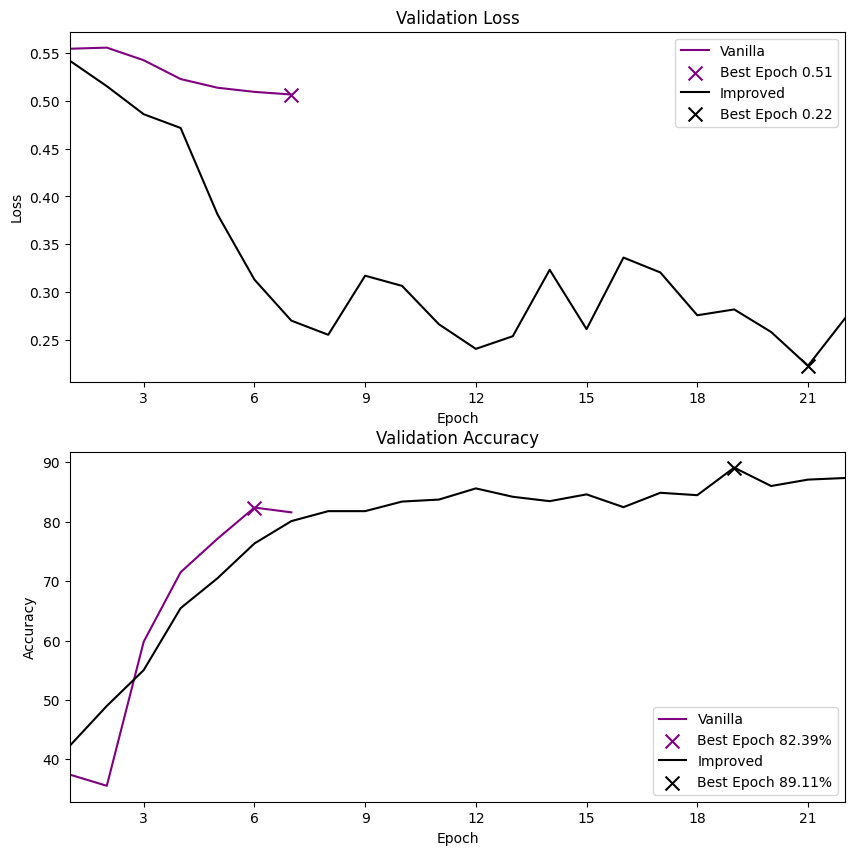

In [173]:
from matplotlib.ticker import MaxNLocator


fig, ax = plt.subplots(2, figsize=(10, 10))

for idx, bifpn_type in enumerate(bifpn_dict):
    train_losses = bifpn_dict[bifpn_type][0]
    val_losses = bifpn_dict[bifpn_type][1]
    train_acc = bifpn_dict[bifpn_type][2]
    val_acc = bifpn_dict[bifpn_type][3]

    ax[0].plot(range(1, len(val_losses) + 1), val_losses, label=f'{bifpn_type.title()}', color=colors[idx + 4])

    # if idx == 1:
    ax[0].scatter(val_losses.index(min(val_losses)) + 1, min(val_losses), marker='x', color=colors[idx + 4], s=100, label=f'Best Epoch {min(val_losses):.2f}')
    # else:
    #     plt.scatter(val_losses.index(min(val_losses)) + 1, min(val_losses), marker='x', color='red', s=100)

    ax[0].set_title('Validation Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[0].set_xlim(1, 22)

    ax[1].plot(range(1, len(val_acc) + 1), val_acc, label=f'{bifpn_type.title()}', color=colors[idx + 4])
    
    # if idx == 1:
    ax[1].scatter(val_acc.index(max(val_acc)) + 1, max(val_acc), marker='x', color=colors[idx + 4], s=100, label=f'Best Epoch {max(val_acc):.2f}%')
    # else:
    #     plt.scatter(val_acc.index(max(val_acc)) + 1, max(val_acc), marker='x', color='red', s=100)

    ax[1].set_title('Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].set_xlim(1, 22)


ax[0].legend()
ax[1].legend()
plt.show()


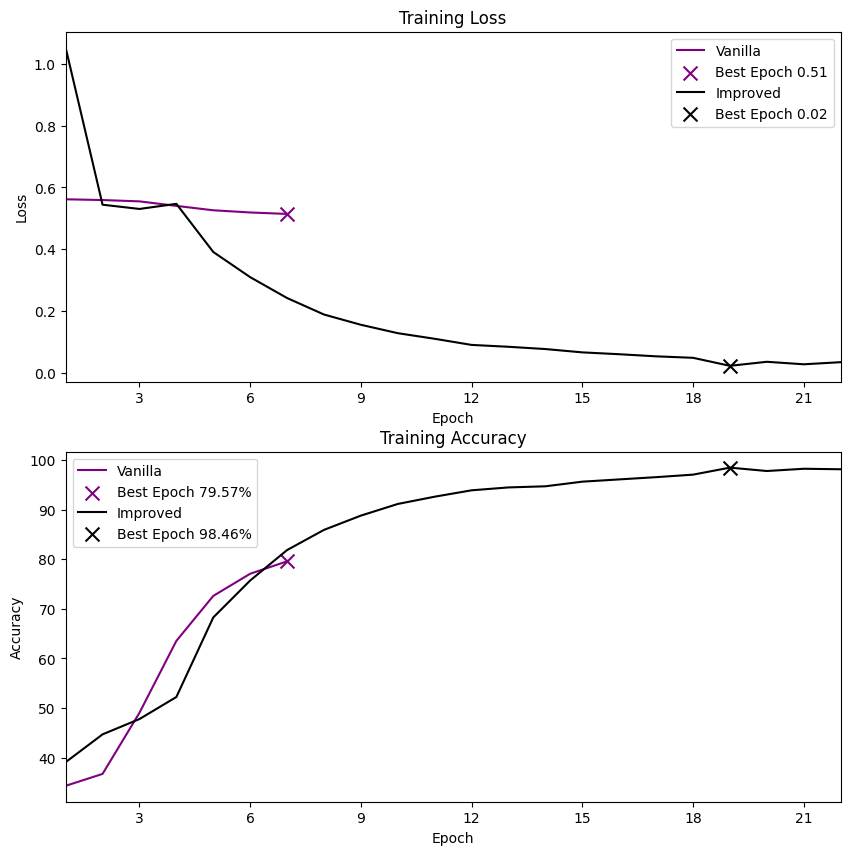

In [174]:
 
fig, ax = plt.subplots(2, figsize=(10, 10))

for idx, bifpn_type in enumerate(bifpn_dict):
    train_losses = bifpn_dict[bifpn_type][0]
    val_losses = bifpn_dict[bifpn_type][1]
    train_acc = bifpn_dict[bifpn_type][2]
    val_acc = bifpn_dict[bifpn_type][3]

    ax[0].plot(range(1, len(train_losses) + 1), train_losses, label=f'{bifpn_type.title()}', color=colors[idx + 4])
    
    # if idx == 1:
    ax[0].scatter(train_losses.index(min(train_losses)) + 1, min(train_losses), marker='x', color=colors[idx + 4], s=100, label=f'Best Epoch {min(train_losses):.2f}')
    ax[0].set_title('Training Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[0].set_xlim(1, 22)

    ax[1].plot(range(1, len(train_acc) + 1), train_acc, label=f'{bifpn_type.title()}', color=colors[idx + 4])

    # if idx == 1:
    ax[1].scatter(train_acc.index(max(train_acc)) + 1, max(train_acc), marker='x', color=colors[idx + 4], s=100, label=f'Best Epoch {max(train_acc):.2f}%')
    ax[1].set_title('Training Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].set_xlim(1, 22)

ax[0].legend()
ax[1].legend()
plt.show()


    
    

68.71794871794872
50
72.56410256410255
50
70.51282051282051
50
73.33333333333333
50


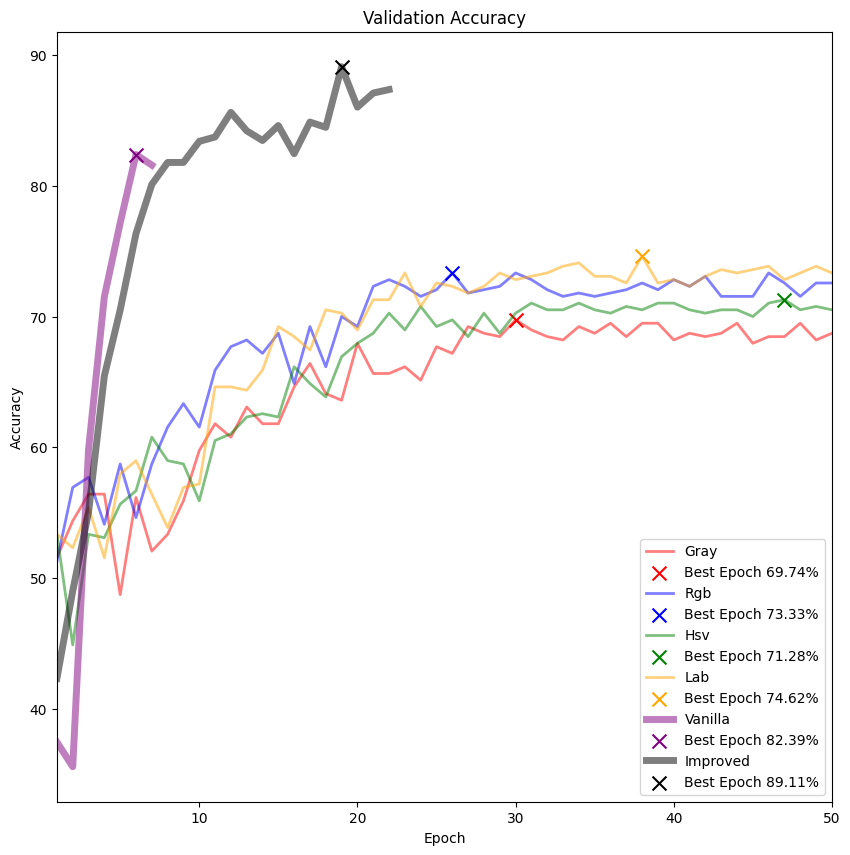

In [140]:

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

colors = ['red', 'blue', 'green', 'orange', 'purple', 'black', 'pink', 'brown', 'gray', 'olive', 'cyan']
for idx, color_space in enumerate(result_dict):
    val_losses = []
    train_losses = []
    val_acc = []

    for i in range(50):
        val_losses.append(result_dict[color_space][str(i)][0])
        train_losses.append(result_dict[color_space][str(i)][1])
        val_acc.append(result_dict[color_space][str(i)][2] * 100)
    print(val_acc[49])
    print(len(val_acc))
    ax.plot(range(1, len(val_acc) + 1), val_acc, label=f'{color_space.title()}', color=colors[idx], alpha=0.5, linewidth=2)

    plt.scatter(val_acc.index(max(val_acc)) + 1, max(val_acc), marker='x', color=colors[idx], s=100, label=f'Best Epoch {max(val_acc):.2f}%')

    ax.set_title('Validation Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_xlim(1, 50)


for idx, bifpn_type in enumerate(bifpn_dict):
    val_acc = bifpn_dict[bifpn_type][3]
    ax.plot(range(1, len(val_acc) + 1), val_acc, label=f'{bifpn_type.title()}', alpha=0.5, linewidth=5, color=colors[idx + 4])

    plt.scatter(val_acc.index(max(val_acc)) + 1, max(val_acc), marker='x', color=colors[idx + 4], s=100, label=f'Best Epoch {max(val_acc):.2f}%')

ax.legend()
plt.show()
